In [47]:
# import pandas as pd
# # timezone-aware
# start_tz = pd.Timestamp("2026-02-17 10:00:00", tz="Europe/Prague")
# end_tz   = pd.Timestamp("2026-02-18 8:00:00", tz="Europe/Prague")

# # timezone-naive
# start_naive = start_tz.tz_localize(None)
# end_naive   = end_tz.tz_localize(None)

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# --- GLOBÁLNÍ PROMĚNNÉ ---
start_tz = None
end_tz = None
start_naive = None
end_naive = None

# --- POSUVNÍK ---
slider = widgets.IntSlider(
    value=22,
    min=1,
    max=48,
    step=1,
    description="Kolik hodin:",
    continuous_update=False
)

# --- DATUM END ---
import datetime

end_date = widgets.DatePicker(
    description="End datum:",
    disabled=False,
    value=datetime.date.today()
)


# --- HODINA END ---
now = datetime.datetime.now()
next_hour = (now.hour + 1) % 24

end_hour = widgets.Dropdown(
    options=[f"{h:02d}" for h in range(24)],
    value=f"{next_hour:02d}",
    description="End hodina:"
)

# --- TLAČÍTKO ---
button = widgets.Button(
    description="Vypočítat",
    button_style="success"
)

# --- OUTPUT BOX ---
out = widgets.Output()

display(slider, end_date, end_hour, button, out)

def compute_times(hours_back, end_date_value, end_hour_value):
    end_tz = pd.Timestamp(
        year=end_date_value.year,
        month=end_date_value.month,
        day=end_date_value.day,
        hour=int(end_hour_value),
        minute=0,
        second=0,
        tz="Europe/Prague"
    )

    start_tz = end_tz - pd.Timedelta(hours=hours_back)

    start_naive = start_tz.tz_localize(None)
    end_naive   = end_tz.tz_localize(None)

    return start_tz, end_tz, start_naive, end_naive

def on_button_click(b):
    global start_tz, end_tz, start_naive, end_naive

    with out:
        out.clear_output()

        if end_date.value is None:
            print("❗ Vyber prosím end datum.")
            return

        # ULOŽENÍ DO GLOBÁLNÍCH PROMĚNNÝCH
        start_tz, end_tz, start_naive, end_naive = compute_times(
            slider.value,
            end_date.value,
            end_hour.value
        )

        print("start_tz:   ", start_tz)
        print("start_naive:", start_naive)
        print("end_tz:     ", end_tz)
        print("end_naive:  ", end_naive)
        print("-" * 40)

button.on_click(on_button_click)


IntSlider(value=22, continuous_update=False, description='Kolik hodin:', max=48, min=1)

DatePicker(value=datetime.date(2026, 2, 23), description='End datum:', step=1)

Dropdown(description='End hodina:', index=10, options=('00', '01', '02', '03', '04', '05', '06', '07', '08', '…

Button(button_style='success', description='Vypočítat', style=ButtonStyle())

Output()

In [2]:
import os

PI = "pi@192.168.11.89"
DEST = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle"

FILES = [
    "/home/pi/teplota_pradelna.csv",
    "/home/pi/teplota_log.csv",
    "/home/pi/netatmo/climate.log",
    "/home/pi/netatmo/netatmo_climate.csv",
]

scp_cmd = "scp " + " ".join(f"{PI}:{f}" for f in FILES) + f' "{DEST}"'
os.system(scp_cmd)


0

## Zobrazení poslední hodiny teplota_log.csv

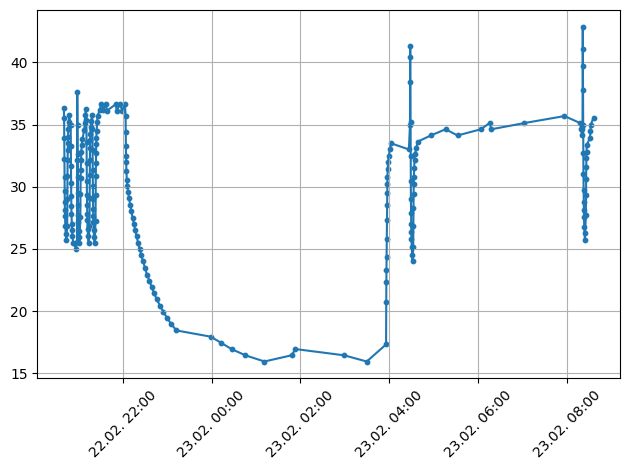

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import zoneinfo

ax = plt.gca()
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d.%m. %H:%M', tz=zoneinfo.ZoneInfo("Europe/Prague"))
)
plt.xticks(rotation=45)

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = (
    pd.to_datetime(df["Time"], errors="coerce") 
    .dt.tz_localize("Europe/Prague") # ← DŮLEŽITÉ 
)
              
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=12)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
 
df.tail(10)



,Time,Value
3693,2026-02-23 08:25:46+01:00,29.375
3694,2026-02-23 08:25:57+01:00,30.625
3695,2026-02-23 08:26:08+01:00,31.625
3696,2026-02-23 08:26:18+01:00,32.312
3697,2026-02-23 08:26:29+01:00,32.812
3698,2026-02-23 08:26:51+01:00,33.375
3699,2026-02-23 08:31:12+01:00,33.937
3700,2026-02-23 08:31:45+01:00,34.500
3701,2026-02-23 08:32:18+01:00,35.000
3702,2026-02-23 08:35:56+01:00,35.562


## Vytvoření df_netatmo ze souboru netatmo_data.csv

In [5]:
import pandas as pd

# Cesta k souboru
path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení dat - tentokrát bez skiprows, protože data začínají hned
df_netatmo = pd.read_csv(path)

# 1) převod z UNIX sekund na datetime
df_netatmo["timestamp"] = ( 
    pd.to_datetime(df_netatmo["timestamp"], unit="s", utc=True) 
    .dt.tz_convert("Europe/Prague") 
)

# 2) pokud chceš formátovaný textový sloupec
df_netatmo["timestamp_str"] = df_netatmo["timestamp"].dt.strftime("%d.%m.%Y %H:%M:%S")


# Ukázka dat
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str
3869,2026-02-23 08:20:09+01:00,22.1,7.7,22,True,1015.0,23.02.2026 08:20:09
3870,2026-02-23 08:25:09+01:00,22.1,7.7,22,True,1014.9,23.02.2026 08:25:09
3871,2026-02-23 08:30:15+01:00,22.1,7.8,22,True,1014.9,23.02.2026 08:30:15
3872,2026-02-23 08:40:12+01:00,22.1,7.9,22,True,1014.9,23.02.2026 08:40:12
3873,2026-02-23 08:45:07+01:00,22.1,7.9,22,True,1014.9,23.02.2026 08:45:07
3874,2026-02-23 08:50:10+01:00,22.1,8.0,22,True,1015.1,23.02.2026 08:50:10
3875,2026-02-23 08:55:07+01:00,22.1,8.1,22,True,1015.0,23.02.2026 08:55:07
3876,2026-02-23 09:00:25+01:00,22.1,8.1,22,True,1015.0,23.02.2026 09:00:25
3877,2026-02-23 09:05:10+01:00,22.1,8.2,22,True,1015.0,23.02.2026 09:05:10
3878,2026-02-23 09:10:11+01:00,22.1,8.3,22,True,1015.0,23.02.2026 09:10:11


### Výpočet boiler_water_2 z temp_outdoor v df_netatmo, který byl vytvořen výše

In [6]:
import pandas as pd


# 3) Nová křivka podle bodů A(-20,15) a B(40,33) 
def hokejka3(temp_in):
    if temp_in <= 10:
        return -0.233333 * temp_in + 35.333333
    else:
        return 33

# Sloupec Boiler_water
# df_netatmo["Boiler_water"] = df_netatmo["temp_outdoor"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temp_outdoor"].apply(hokejka3)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)

html_table1 = (
    df_netatmo.tail(10)
    .style.set_table_attributes('class="table table-hover table-bordered"')
    .set_properties(**{'text-align': 'center'})
    .background_gradient(cmap="coolwarm")
    .to_html()
)


## Nový soubor raspberry teplota_log.csv

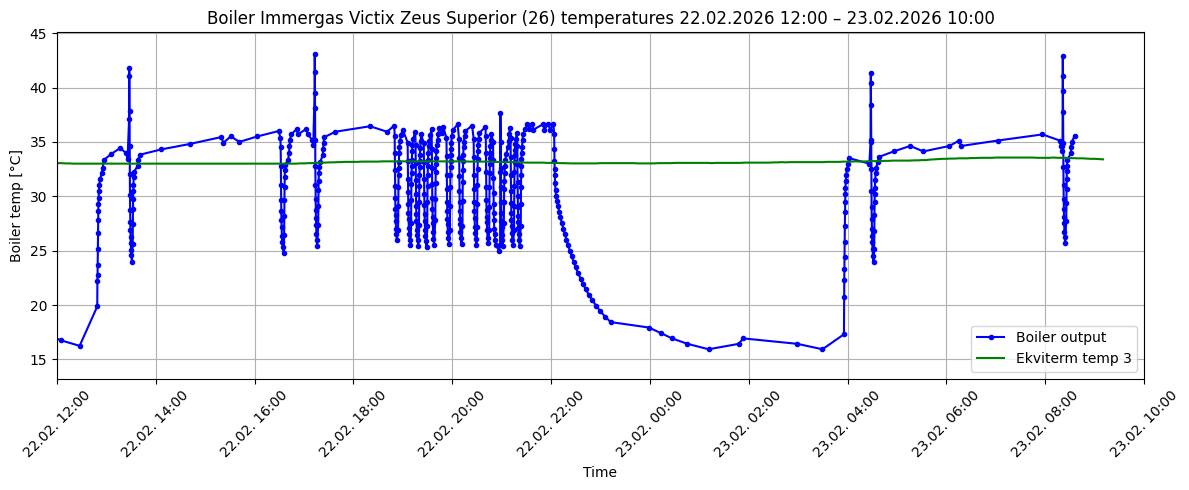

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import zoneinfo

# --- ČASOVÉ OKNO (musí mít stejnou zónu jako Netatmo) ---
# start_time = pd.Timestamp("2026-02-14 10:00:00", tz="Europe/Prague")
# end_time   = pd.Timestamp("2026-02-15 09:00:00", tz="Europe/Prague")

plt.figure(figsize=(12,5))
ax = plt.gca()

# ---------------------------------------------------------
# 1) KOTEL – převedeme do stejné zóny jako Netatmo
# ---------------------------------------------------------
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

if df["Time"].dt.tz is None:
    df["Time"] = df["Time"].dt.tz_localize("Europe/Prague")
else:
    df["Time"] = df["Time"].dt.tz_convert("Europe/Prague")

ax.plot(
    df["Time"],
    df["Value"],
    marker=".",
    color="blue",
    label="Boiler output"
)

# ---------------------------------------------------------
# 2) NETATMO – timestamp je UTC → převedeme do Europe/Prague
# ---------------------------------------------------------
df_netatmo["time_local"] = (
    pd.to_datetime(df_netatmo["timestamp"], unit="s", utc=True)
    .dt.tz_convert("Europe/Prague")
)

ax.plot(
    df_netatmo["time_local"],
    df_netatmo["Boiler_water_2"],
    color="green",
    label="Ekviterm temp 3"
)

# ---------------------------------------------------------
# 3) ČASOVÉ OKNO
# ---------------------------------------------------------
ax.set_xlim(start_tz, end_tz)

# ---------------------------------------------------------
# 4) FORMÁT OSY X – nastavíme Europe/Prague
# ---------------------------------------------------------
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d.%m. %H:%M', tz=zoneinfo.ZoneInfo("Europe/Prague"))
)

plt.xticks(rotation=45)

plt.title(
    f"Boiler Immergas Victix Zeus Superior (26) temperatures "
    f"{start_naive:%d.%m.%Y %H:%M} – {end_naive:%d.%m.%Y %H:%M}"
)

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Import souboru Climate.csv

In [8]:
import pandas as pd

df_climate = pd.read_csv(path)

df_climate["time_local"] = (
    pd.to_datetime(df_climate["timestamp"], unit="s", utc=True)
    .dt.tz_convert("Europe/Prague")
)

df_climate["time_local_str"] = df_climate["time_local"].dt.strftime("%d.%m.%Y %H:%M:%S")

df_climate.tail(10)





,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,time_local,time_local_str
3869,1771831209,22.1,7.7,22,True,1015.0,2026-02-23 08:20:09+01:00,23.02.2026 08:20:09
3870,1771831509,22.1,7.7,22,True,1014.9,2026-02-23 08:25:09+01:00,23.02.2026 08:25:09
3871,1771831815,22.1,7.8,22,True,1014.9,2026-02-23 08:30:15+01:00,23.02.2026 08:30:15
3872,1771832412,22.1,7.9,22,True,1014.9,2026-02-23 08:40:12+01:00,23.02.2026 08:40:12
3873,1771832707,22.1,7.9,22,True,1014.9,2026-02-23 08:45:07+01:00,23.02.2026 08:45:07
3874,1771833010,22.1,8.0,22,True,1015.1,2026-02-23 08:50:10+01:00,23.02.2026 08:50:10
3875,1771833307,22.1,8.1,22,True,1015.0,2026-02-23 08:55:07+01:00,23.02.2026 08:55:07
3876,1771833625,22.1,8.1,22,True,1015.0,2026-02-23 09:00:25+01:00,23.02.2026 09:00:25
3877,1771833910,22.1,8.2,22,True,1015.0,2026-02-23 09:05:10+01:00,23.02.2026 09:05:10
3878,1771834211,22.1,8.3,22,True,1015.0,2026-02-23 09:10:11+01:00,23.02.2026 09:10:11


## Setpoint a teplota kotle

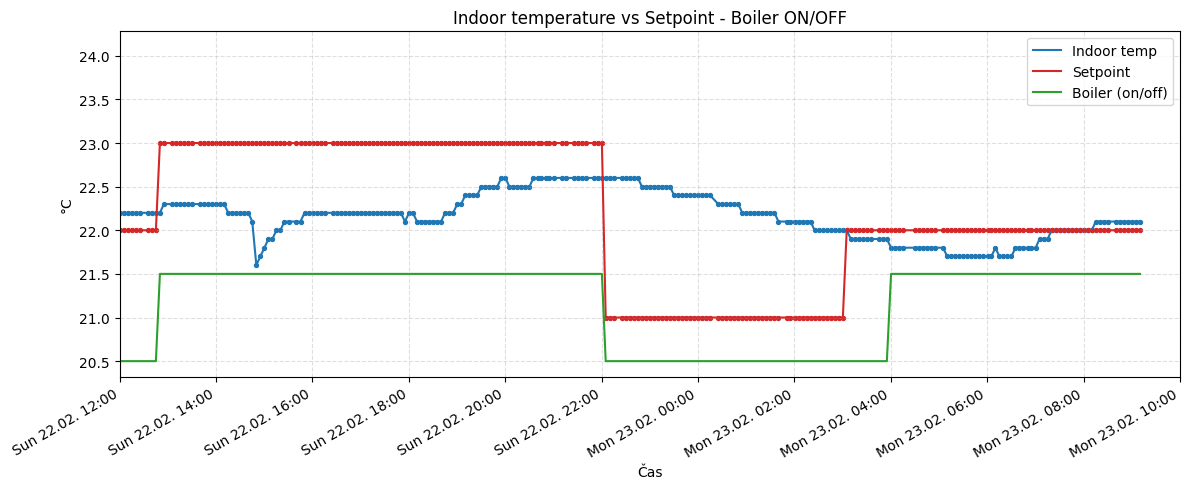

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Převod timestamp → datetime + posun o 1 hodinu
df_climate["time"] = pd.to_datetime(df_climate["timestamp"], unit="s") + pd.to_timedelta(1, "h")

# --- ČASOVÉ OKNO (naivní, protože df_climate["time"] je také naivní) ---


# -----------------------------
# GRAF
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

# Indoor temp
ax.plot(df_climate["time"], df_climate["temp_indoor"], label="Indoor temp",
        color="tab:blue", linewidth=1.5)
ax.scatter(df_climate["time"], df_climate["temp_indoor"], s=8, color="tab:blue")

# Setpoint
ax.plot(df_climate["time"], df_climate["setpoint"], label="Setpoint",
        color="tab:red", linewidth=1.5)
ax.scatter(df_climate["time"], df_climate["setpoint"], s=8, color="tab:red")

# Boiler (0/1) posunutý nahoru
ax.plot(df_climate["time"], df_climate["boiler"] + 20.5,
        label="Boiler (on/off)", color="tab:green", linewidth=1.5)

# --- ČASOVÉ OKNO ---
ax.set_xlim(start_naive, end_naive)

ax.set_title("Indoor temperature vs Setpoint - Boiler ON/OFF")
ax.set_xlabel("Čas")
ax.set_ylabel("°C")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()




In [10]:
from IPython.display import Markdown, display

df_net = df_netatmo.sort_values("timestamp")

# poslední start (False → True)
starts = (df_net["boiler"] == True) & (df_net["boiler"].shift(1) == False)
last_start = df_net[starts].iloc[-1]["timestamp_str"]

# poslední stop (True → False)
stops = (df_net["boiler"] == False) & (df_net["boiler"].shift(1) == True)
last_stop = df_net[stops].iloc[-1]["timestamp_str"]

# poslední záznam (timestamp)
last_timestamp = df_net.iloc[-1]["timestamp_str"]

# poslední venkovní teplota
last_temp_outdoor = df_net.iloc[-1]["temp_outdoor"]

# poslední tlak vzduchu
last_pressure = df_net.iloc[-1]["pressure"]

# 1) Seřadíme start/stop podle času (nejstarší první)
if last_start <= last_stop:
    kotel_text = (
        f"# 🔥 Poslední start kotle: **{last_start}**\n"
        f"# ❄️ Poslední odstavení kotle: **{last_stop}**\n"
    )
else:
    kotel_text = (
        f"# ❄️ Poslední odstavení kotle: **{last_stop}**\n"
        f"# 🔥 Poslední start kotle: **{last_start}**\n"
    )

# 2) Nejprve vypíšeme log, teplotu, tlak
text = (
    f"# 🕒 Poslední záznam v logu: **{last_timestamp}**\n"
    f"# 🌡️ Poslední venkovní teplota: **{last_temp_outdoor:.1f} °C**\n"
    f"# 🌬️ Poslední tlak vzduchu: **{last_pressure:.1f} hPa**\n"
)

# 3) A až POTOM vypíšeme obě hodnoty kotle v seřazeném pořadí
text += kotel_text

display(Markdown(text))




# 🕒 Poslední záznam v logu: **23.02.2026 09:10:11**
# 🌡️ Poslední venkovní teplota: **8.3 °C**
# 🌬️ Poslední tlak vzduchu: **1015.0 hPa**
# ❄️ Poslední odstavení kotle: **22.02.2026 22:05:06**
# 🔥 Poslední start kotle: **23.02.2026 04:00:19**


## Venkovní teplota a ekviterma

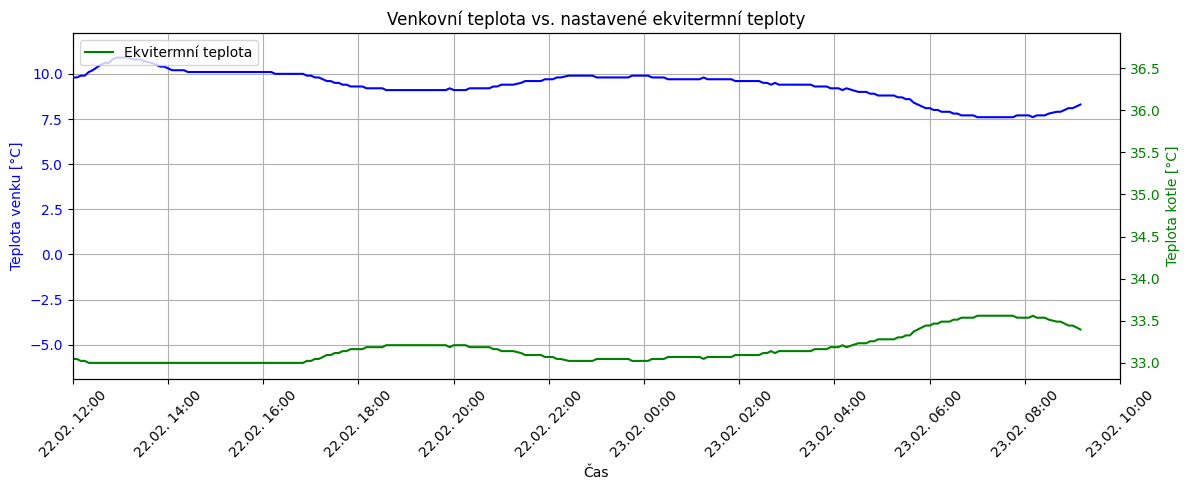

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Posun času o 1 hodinu
df_netatmo["timestamp_shifted"] = df_netatmo["timestamp"] + pd.to_timedelta(1, "h")

fig, ax = plt.subplots(figsize=(12, 5))

# Hlavní osa – venkovní teplota
ax.plot(df_netatmo["timestamp_shifted"], df_netatmo["temp_outdoor"],
        color="blue", label="Teplota venku")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa – teplota kotle
ax2 = ax.twinx()
ax2.plot(df_netatmo["timestamp_shifted"], df_netatmo["Boiler_water_2"],
         color="green", label="Ekvitermní teplota")
ax2.set_ylabel("Teplota kotle [°C]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titulek a popisky
ax.set_title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlim(start_naive, end_naive)

# Legenda
ax2.legend(loc="upper left")

ax.grid(True)
fig.tight_layout()
plt.show()




## Programování ekvitermních křivek

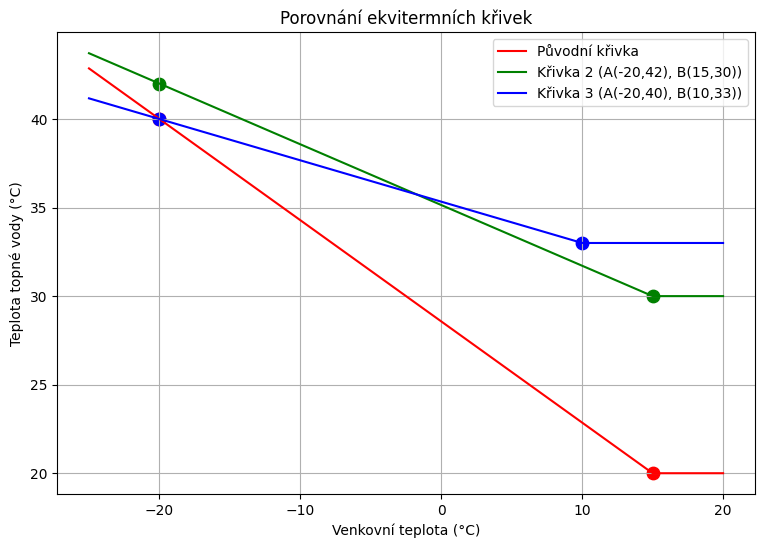

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# 2) Druhá křivka (A(-20,42), B(15,30) – tvoje stará verze)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# 3) Nová křivka podle bodů A(-20,40) a B(10,33) 
def hokejka3(temp_in):
    if temp_in <= 10:
        return -0.233333 * temp_in + 35.333333
    else:
        return 33

# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]
temps_out_3 = [hokejka3(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Křivka 2 (A(-20,42), B(15,30))", color="green")
plt.plot(temps_in, temps_out_3, label="Křivka 3 (A(-20,40), B(10,33))", color="blue")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80)

# Body křivky 2
plt.scatter([-20, 15], [42, 30], color="green", s=80)

# Body křivky 3
plt.scatter([-20, 10], [40, 33], color="blue", s=80)

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

plt.show()


## Tlak vzduchu z Climate

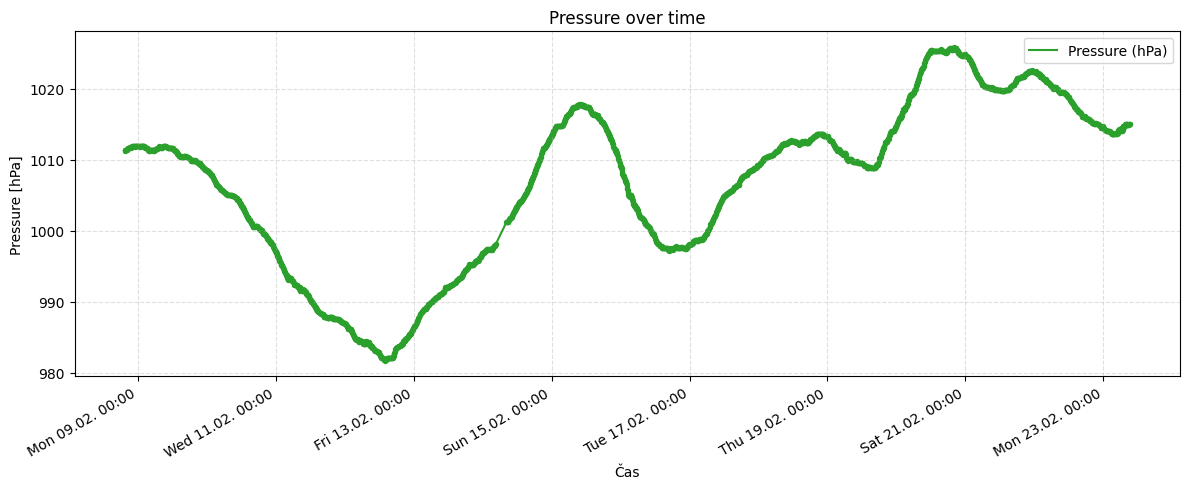

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# GRAF TLAKU
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_climate["time"], df_climate["pressure"],
        label="Pressure (hPa)", color="tab:green", linewidth=1.5)

ax.scatter(df_climate["time"], df_climate["pressure"], s=8, color="tab:green")

ax.set_title("Pressure over time")
ax.set_xlabel("Čas")
ax.set_ylabel("Pressure [hPa]")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()



## Teplota v prádelně

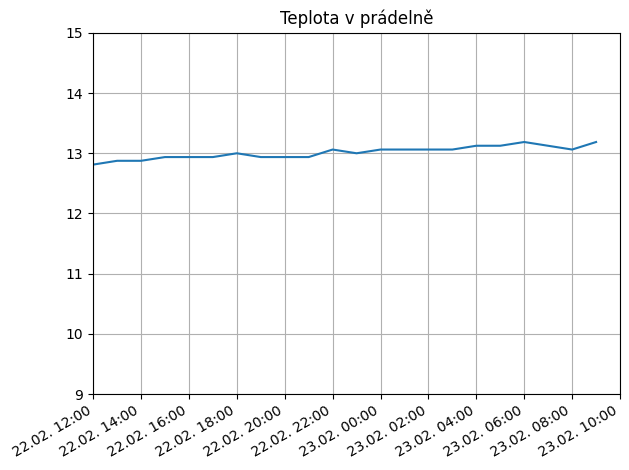

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import mplcursors

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
# df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(9, 15)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"], linestyle="-", marker=None)
# ax.plot(df_pradelna["cas"], df_pradelna["tepl"], marker=".")
# ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=5)
ax.set_xlim(start_naive, end_naive)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()




## Starý soubor teplota_log_old1

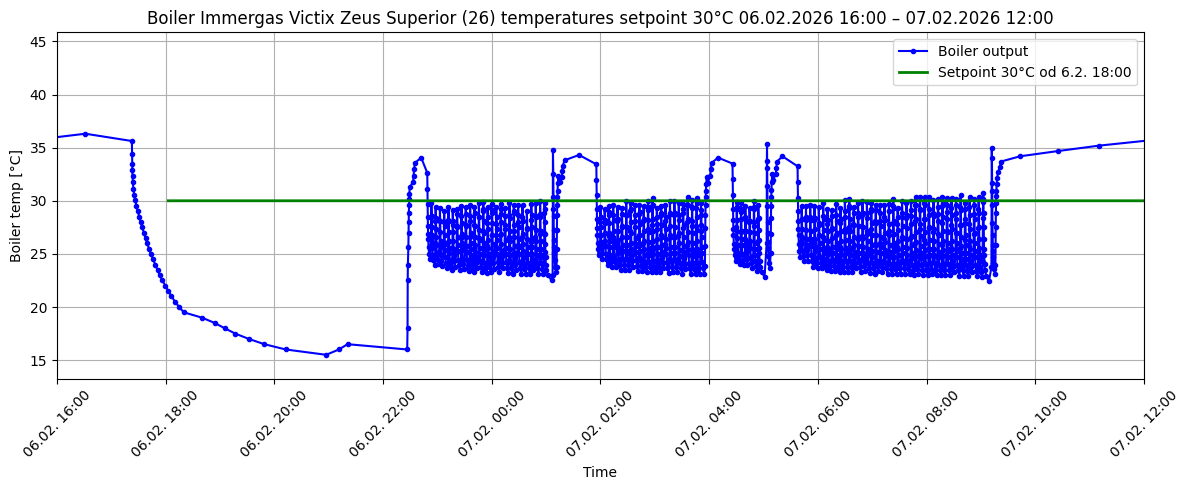

In [15]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Nastavení žádané teploty kotle na 30°C od 6.2. v 18:00 do 7.2. v 9:30 poté bylo nastaveno 33°C

df_old = pd.read_csv("teplota_log_old1.csv", header=None, names=["Time", "Value"])
df_old["Time"] = pd.to_datetime(df_old["Time"], errors="coerce")
df_old["Value"] = pd.to_numeric(df_old["Value"], errors="coerce")
df_old = df_old.dropna().sort_values("Time").drop_duplicates("Time")

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-06 16:00:00")
end_time   = pd.Timestamp("2026-02-07 12:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df_old["Time"], df_old["Value"], marker=".", color="blue", label="Boiler output")

# --- Zelená křivka začínající až 6.2. v 18:00 
start_const = pd.Timestamp("2026-02-06 18:00:00")
mask = df_old["Time"] >= start_const
ax.plot(df_old.loc[mask, "Time"], [30] * mask.sum(), color="green", linewidth=2, label="Setpoint 30°C od 6.2. 18:00")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures setpoint 30°C {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()